# Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

 

# Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


# Dataset:

The dataset has the following columns:
- tweet_id                                                           
- airline_sentiment                                               
- airline_sentiment_confidence                               
- negativereason                                                   
- negativereason_confidence                                    
- airline                                                                    
- airline_sentiment_gold                                              
- name     
- negativereason_gold 
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location 
- user_timezone

In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_column', None)
sns.set()

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
import unicodedata
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix,make_scorer

from sklearn.preprocessing import StandardScaler

PYTHONHASHSEED=0  # step 1: set the PYTHONHASHSEED environment variable to 0 before the program starts

import random
random.seed(28)  # step 2: set `python` built-in pseudo-random generator at a fixed value

import tensorflow as tf
np.random.seed (11)  # step 3: set `numpy` pseudo-random generator at a fixed value
tf.random.set_seed(6) # step 4: set the `tensorflow` pseudo-random generator at a fixed value

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm

In [2]:
nltk.download('punkt')  # for tokenization
nltk.download('stopwords')   # for stopword removal
!python3 -m spacy download en_core_web_sm   # for lemmatization

[nltk_data] Downloading package punkt to
[nltk_data]     /home/liangym2014/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liangym2014/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-10-20 14:26:56.576098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-20 14:26:56.576156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 5.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/liangym2014/venv/meow/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Import Data

In [3]:
airline = pd.read_csv('Tweets.csv')

In [4]:
df = airline.copy()

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.shape

(14640, 15)

- The dataset consists of 14640 rows and 15 columns.
- Missing values present in serveral columns.
- Features with ambiguous name like `airline_sentiment_gold` and `tweet_coord` may need further investigation to understand what they really mean.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- Most columns are objects. Only `tweet_id`, `airline_sentiment_confidence`, `negativereason_confidence` and `retweet_count` are numbers.

## Check Missing Values

In [8]:
# show columns with missing values and the proportion of missing values
def check_missing_values():
    miss_df = pd.DataFrame(df.isnull().sum(), columns = ['# of missing values'])
    miss_df["% of missing values"] = np.round(miss_df['# of missing values']/ df.shape[0] * 100, 2)
    return  miss_df[miss_df["% of missing values"] > 0]

In [9]:
check_missing_values()

,# of missing values,% of missing values
negativereason,5462,37.31
negativereason_confidence,4118,28.13
airline_sentiment_gold,14600,99.73
negativereason_gold,14608,99.78
tweet_coord,13621,93.04
tweet_location,4733,32.33
user_timezone,4820,32.92


- Missing values in `airline_sentiment_gold`, `negativereason_gold`, `tweet_coord` account for 90+% of the total.
- Missing values in `negativereason`, `negativereason_confidence`, `tweet_location` and `user_timezone` account for about 30% of the total.

### Drop `airline_sentiment_gold`

In [10]:
df[df.airline_sentiment_gold.notnull()]  # check airline_sentiment_gold with values

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,negative,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thank...",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,negative,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arriv...,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2135,569343661063823360,neutral,1.0000,NaN,NaN,United,neutral,aushianya,NaN,0,@united I have a question,NaN,2015-02-21 19:51:21 -0800,NaN,NaN
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,negative,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point...,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,negative,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's be...,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,negative,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our t...,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Customer Service Issue,0.4513,United,negative,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,@united rebooked 24 hours after original fligh...,NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,negative,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my fligh...,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,@SouthwestAir What an awesome flight Dallas 2 ...,NaN,2015-02-23 19:42:47 -0800,ny,NaN
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,negative,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 min...",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)


In [11]:
np.all(df.loc[df.airline_sentiment_gold.notnull(), 'airline_sentiment_gold'] == df.loc[df.airline_sentiment_gold.notnull(), 'airline_sentiment'])

True

- `airline_sentiment_gold` is the replicate of `airline_sentiment`. We could drop `airline_sentiment_gold`.

In [12]:
df.drop(columns = ['airline_sentiment_gold'], inplace = True)

### Treat `negativereason` and `negativereason_gold`

In [13]:
valid_negativereasons = df[df.negativereason_gold.notnull()]  # check negativereason_gold with values
valid_negativereasons

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thank...",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arriv...,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point...,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's be...,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our t...,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Customer Service Issue,0.4513,United,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,@united rebooked 24 hours after original fligh...,NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my fligh...,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 min...",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)
5341,569179898532761600,negative,1.0000,Customer Service Issue,0.9256,Southwest,HDTeem,Customer Service Issue,0,@SouthwestAir I've been on hold for over an ho...,NaN,2015-02-21 09:00:37 -0800,"Baton Rouge, LA",Central Time (US & Canada)
5810,568581908075933696,negative,0.9658,Bad Flight,0.6623,Southwest,abyrley,Bad Flight,1,@SouthwestAir please do something about the sp...,NaN,2015-02-19 17:24:25 -0800,"Raleigh, NC",NaN


In [14]:
for i, r in valid_negativereasons.iterrows():
    if r['negativereason'] not in r['negativereason_gold']:
        print(i)

12038


- In most cases, elements in `negativereason` are already included in `negativereason_gold`. Only at row 12038, the two don't overlap:

In [15]:
df[df.index == 12038]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12038,570294451261874177,negative,1.0,longlines,0.4686,Delta,DetroitRonin,Customer Service Issue,0,@DeltaAssist now at 57 minutes waiting on Silv...,NaN,2015-02-24 10:49:27 -0800,Thataway,Eastern Time (US & Canada)


In [16]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [17]:
df.negativereason_gold.value_counts()

Customer Service Issue                      12
Late Flight                                  4
Cancelled Flight                             3
Can't Tell                                   3
Cancelled Flight\nCustomer Service Issue     2
Bad Flight                                   1
Customer Service Issue\nCan't Tell           1
Flight Attendant Complaints                  1
Late Flight\nLost Luggage                    1
Customer Service Issue\nLost Luggage         1
Lost Luggage\nDamaged Luggage                1
Late Flight\nFlight Attendant Complaints     1
Late Flight\nCancelled Flight                1
Name: negativereason_gold, dtype: int64

- Sometimes there're more than one issue that make customers unhappy. These elements in `negativereason_gold` are the combinations of the elements in `negativereason`.

**Merge two columns into one, stored in `negativereason`. Drop `negativereason_gold`.**

In [18]:
valid_negativereasons.loc[12038, 'negativereason_gold'] += '\n' + valid_negativereasons.loc[12038, 'negativereason']

for i, r in valid_negativereasons.iterrows():
    df.loc[i, 'negativereason'] = r['negativereason_gold']
    
df[df.index.isin(valid_negativereasons.index)]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight\nFlight Attendant Complaints,0.7684,United,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thank...",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight\nLost Luggage,0.6048,United,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arriv...,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point...,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's be...,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our t...,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Cancelled Flight\nCustomer Service Issue,0.4513,United,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,@united rebooked 24 hours after original fligh...,NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my fligh...,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 min...",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)
5341,569179898532761600,negative,1.0000,Customer Service Issue,0.9256,Southwest,HDTeem,Customer Service Issue,0,@SouthwestAir I've been on hold for over an ho...,NaN,2015-02-21 09:00:37 -0800,"Baton Rouge, LA",Central Time (US & Canada)
5810,568581908075933696,negative,0.9658,Bad Flight,0.6623,Southwest,abyrley,Bad Flight,1,@SouthwestAir please do something about the sp...,NaN,2015-02-19 17:24:25 -0800,"Raleigh, NC",NaN


In [19]:
df.drop(columns = ['negativereason_gold'], inplace = True)

In [20]:
check_missing_values()

,# of missing values,% of missing values
negativereason,5462,37.31
negativereason_confidence,4118,28.13
tweet_coord,13621,93.04
tweet_location,4733,32.33
user_timezone,4820,32.92


### Check the relation between `airline_sentiment` and `negativereason`, `negativereason_confidence`

In [21]:
df.loc[df.negativereason.isnull(), 'airline_sentiment'].value_counts()

neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [22]:
df.loc[df.negativereason_confidence.isnull(), 'airline_sentiment'].value_counts()

neutral     2085
positive    2033
Name: airline_sentiment, dtype: int64

- The missing values in `negativereason` and `negativereason_confidence` correspond to positive or neutral sentiment. So they're actually "N/A" rather than missing.


### Drop `tweet_coord`

In [23]:
df.tweet_coord.value_counts()

[0.0, 0.0]                     164
[40.64656067, -73.78334045]      6
[40.64646912, -73.79133606]      3
[32.91792297, -97.00367737]      3
[40.68994668, -73.91637642]      2
                              ... 
[40.7740308, -73.8674526]        1
[41.9809313, -87.9063148]        1
[30.30630631, -97.71394697]      1
[22.31355693, 113.92636768]      1
[25.79939784, -80.27038889]      1
Name: tweet_coord, Length: 832, dtype: int64

- `tweet_coord` shows the coordinates of the contributors. We could drop it.

In [24]:
df.drop(columns = ['tweet_coord'], inplace = True)

## Drop `tweet_id` and `name`
- `tweet_id` and `name` don't contain much useful information for our analysis. We could drop them.

In [25]:
df.drop(columns = ['tweet_id', 'name'], inplace = True)

## Check unique values

In [26]:
for col in df.columns:
    print(col, ":", df[col].nunique())

airline_sentiment : 3
airline_sentiment_confidence : 1023
negativereason : 18
negativereason_confidence : 1410
airline : 6
retweet_count : 18
text : 14427
tweet_created : 14247
tweet_location : 3081
user_timezone : 85


## Check `tweet_location`

In [27]:
list(df.tweet_location.unique()[:30])  # show the top 30 tweet locations

[nan,
 'Lets Play',
 'San Francisco CA',
 'Los Angeles',
 'San Diego',
 '1/1 loner squad',
 'NYC',
 'San Francisco, CA',
 'palo alto, ca',
 'west covina',
 'this place called NYC',
 'Somewhere celebrating life. ',
 'Boston | Waltham',
 'Boston, MA ',
 '714',
 'San Mateo, CA & Las Vegas, NV',
 'Brooklyn',
 'California, San Francisco',
 'Washington DC',
 'Texas',
 'Worldwide',
 'Central Texas',
 "i'm creating a monster ",
 'Iowa City',
 'Georgia',
 'Turks and caicos',
 'Oakland via Midwest ',
 'New York, NY',
 'Northern Virginia',
 'Los Angeles / Atlanta']

- Representations of `tweet_location` are flexible. Some are real geographic locations, while others are not. 
- Granularity of geographic locations is from borough/city to state/country. 

## Split `tweet_created` into year, month, day and hour

In [28]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

In [29]:
df['year'] = df['tweet_created'].dt.year
df['month'] = df['tweet_created'].dt.month
df['day'] = df['tweet_created'].dt.day
df['hour'] = df['tweet_created'].dt.hour

In [30]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),2015,2,24,11
1,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11
2,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),2015,2,24,11
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11


## Data description

In [31]:
df.describe(include = ['object'])

,airline_sentiment,negativereason,airline,text,tweet_location,user_timezone
count,14640,9178,14640,14640,9907,9820
unique,3,18,6,14427,3081,85
top,negative,Customer Service Issue,United,@united thanks,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2908,3822,6,157,3744


In [32]:
df.describe()

,airline_sentiment_confidence,negativereason_confidence,retweet_count,year,month,day,hour
count,14640.000000,10522.000000,14640.000000,14640.0,14640.0,14640.000000,14640.000000
mean,0.900169,0.638298,0.082650,2015.0,2.0,20.947473,12.319945
std,0.162830,0.330440,0.745778,0.0,0.0,2.170646,5.306285
min,0.335000,0.000000,0.000000,2015.0,2.0,16.000000,0.000000
25%,0.692300,0.360600,0.000000,2015.0,2.0,19.000000,8.000000
50%,1.000000,0.670600,0.000000,2015.0,2.0,22.000000,12.000000
75%,1.000000,1.000000,0.000000,2015.0,2.0,23.000000,17.000000
max,1.000000,1.000000,44.000000,2015.0,2.0,24.000000,23.000000


- Most of the sentiments are negative.
- Customer Service Issue is the #1 complaint.
- Among six airlines, United appears most frequently.
- About 30% contributors are from Eastern Time (US & Canada) time zone.
- All the data was collected during 2015-2-16 to 2015-2-24.
- Most of the tweets don't get retweeted. But some outliers get as many as 44 retweets.

# EDA
## Univariate Analysis

In [33]:
num_categories = 40

def count_plotx(col, first_n = 0):
    """
    Show a vertical countplot of the first_n categories.
    """
    if df[col].nunique() < num_categories:   # if number of categories < num_categories, display all of them. otherwise, only display first_n categories.
        first_n = df[col].nunique()
    ax = sns.countplot(x = df[col], order = df[col].value_counts().index[:first_n])
    for p in ax.patches:
        percent = np.round(p.get_height() / df.shape[0] * 100, 2)
        plt.annotate(str(percent) + '%', (p.get_x() + p.get_width()/2 - 0.2, p.get_y() + p.get_height()))
        
def count_ploty(col, first_n = 0):
    """
    Show a horizontal countplot of the first_n categories.
    """    
    if df[col].nunique() < num_categories:   # if number of categories < num_categories, display all of them. otherwise, only display first_n categories.
        first_n = df[col].nunique()
    ax = sns.countplot(y = df[col], order = df[col].value_counts().index[:first_n])
    for p in ax.patches:
        percent = np.round(p.get_width() / df.shape[0] * 100, 2)
        plt.annotate(str(percent) + '%', (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2))        

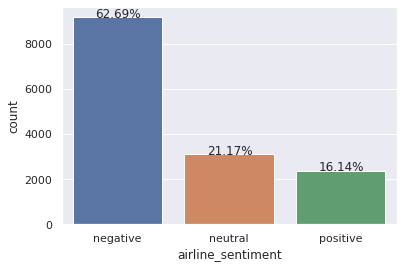

In [34]:
count_plotx('airline_sentiment')

- Negative reviews account for 62.69%, followed by neutral reviews of 21.17%.

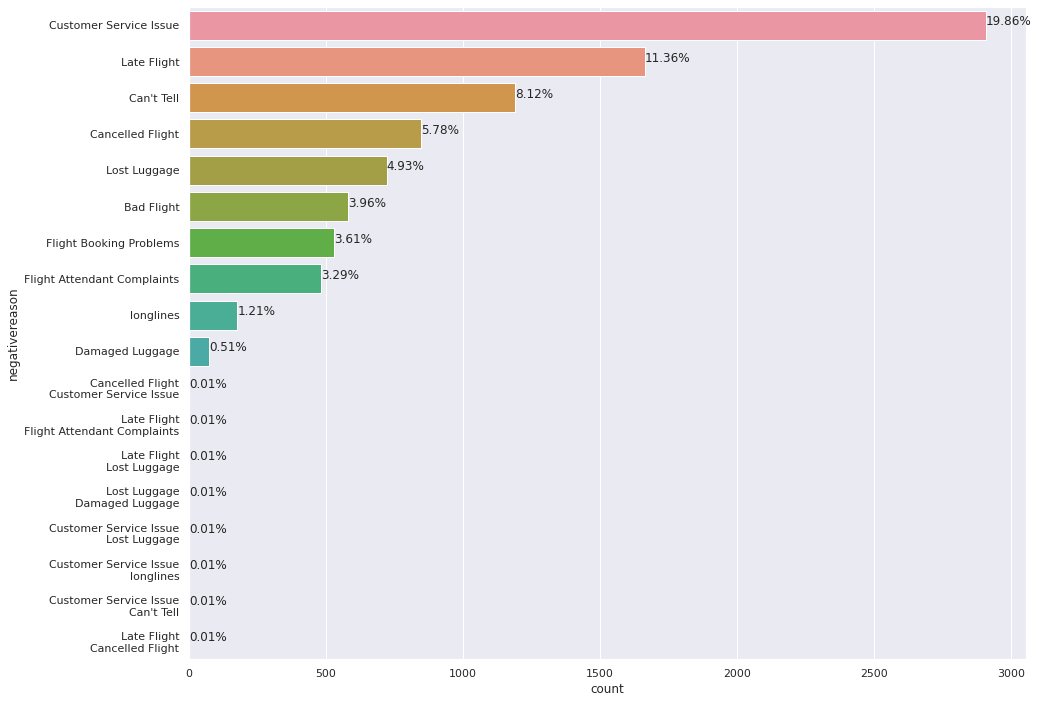

In [35]:
plt.figure(figsize = (15,12))
count_ploty('negativereason')

- `Customer Service Issue` accounts for about 20% of negative reasons, followed by `Late Flight`. It's noticeable that the #3 negative reason is `Can't Tell`. It deserves further research on what it actually means. It may indicate customers are not comfortable with the service in many minor and subtle ways.
- Less than 1% complaints associate with multiple negative reasons.

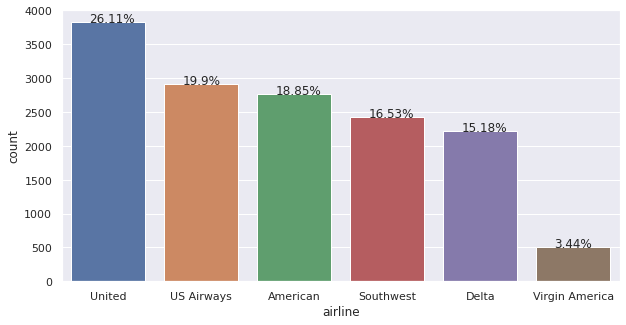

In [36]:
plt.figure(figsize = (10,5))
count_plotx('airline')

- Totally 6 airlines. 26.11% of the reviews are about `United`, followed by `US Airways` of 19.9% and `American` of 18.85%.

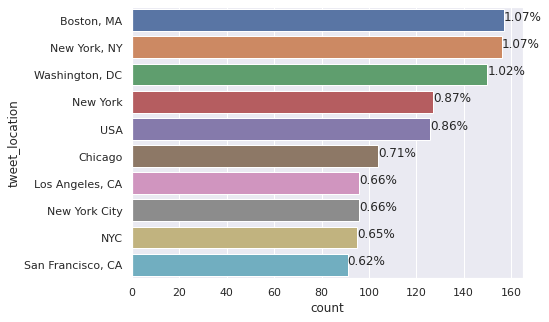

In [37]:
plt.figure(figsize = (7,5))
count_ploty('tweet_location', 10)

- Top 10 tweet locations are all in USA.

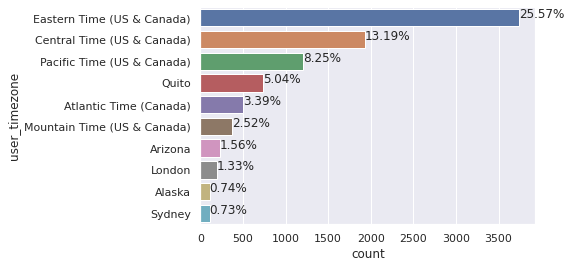

In [38]:
count_ploty('user_timezone', 10)

- Most of the top 10 user timezone are located at North America. About 5% are from Quito, Ecuador.

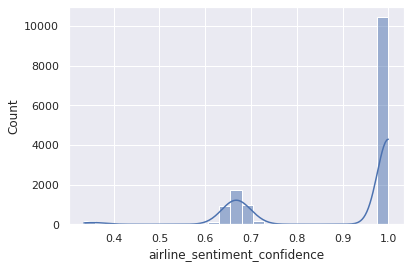

In [39]:
sns.histplot(df['airline_sentiment_confidence'], kde = True);

- `airline_sentiment_confidence` are mostly 1.0. But it's unclear what this feature exactly means.

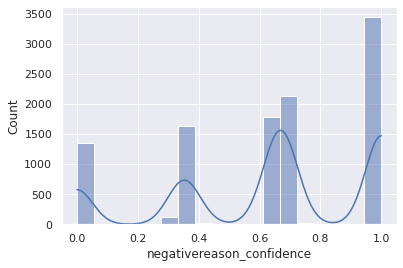

In [40]:
sns.histplot(df['negativereason_confidence'], kde = True);

- `negativereason_confidence` are mostly greater than 0.5. But it's unclear what this feature exactly means.

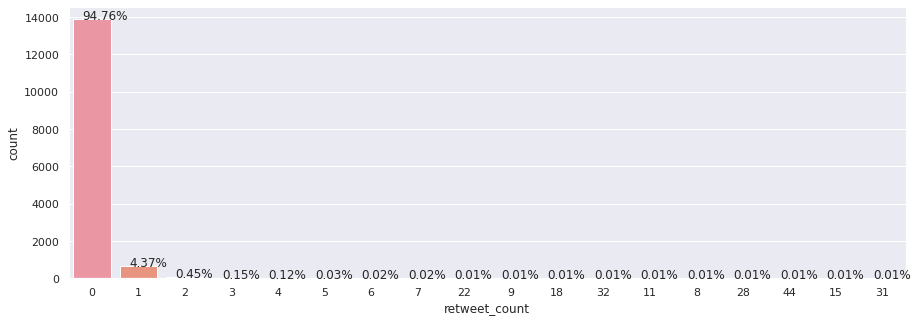

In [41]:
plt.figure(figsize = (15,5))
count_plotx('retweet_count', 0)

- Most of the tweets get 0 ~ 1 retweet. But some outliers could get as many as 44 retweets.

In [42]:
df[df.retweet_count == 44]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
11596,negative,1.0,Late Flight,1.0,US Airways,44,@USAirways 5 hr flight delay and a delay when ...,2015-02-17 20:06:21-08:00,NaN,Eastern Time (US & Canada),2015,2,17,20


In [43]:
df[df.retweet_count == 44].text.values

array(['@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks)'],
      dtype=object)

- The one that got so many retweets is about a 5 hour delay flight with US Airways. It's probably from passengers who were delayed in this flight and full of frustration and anger.

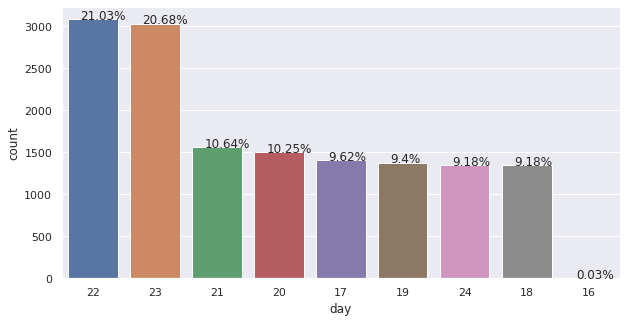

In [44]:
plt.figure(figsize = (10,5))
count_plotx('day', 0)

- Most of the data was collected during 2015-2-17 to 2015-2-24.

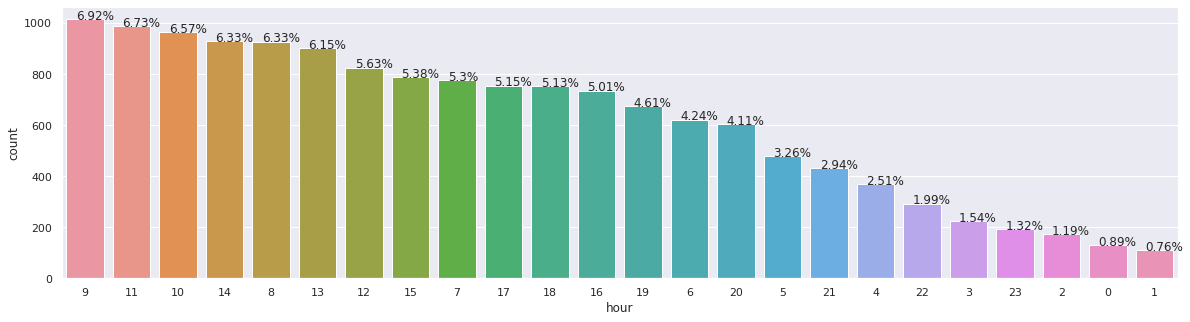

In [45]:
plt.figure(figsize = (20,5))
count_plotx('hour', 0)

- Most of the tweets were created during 7:00 - 18:00. Part of them were created during unusual time slots between 21:00 - 5:00.

## Bivariate Analysis
### `airline_sentiment` vs `airline`

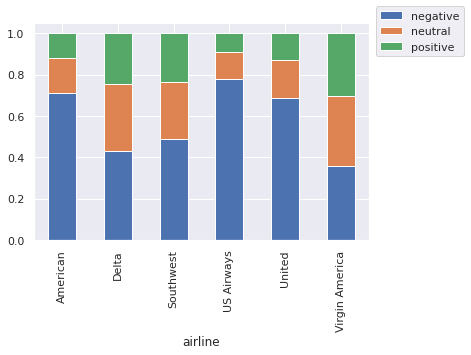

In [46]:
pd.crosstab(index = df.airline, columns = df.airline_sentiment, normalize = 'index').plot(kind = 'bar', stacked = True);
plt.legend(bbox_to_anchor = (1.3,1.1), loc = 'upper right');

- At least 70% of the tweets about `America`, `US Airways` and `United` are negative.
- `Virgin America` is popular among customers, with less than 40% negative feedbacks and about 30% positive feedbacks.

### `negativereason` vs `airline`

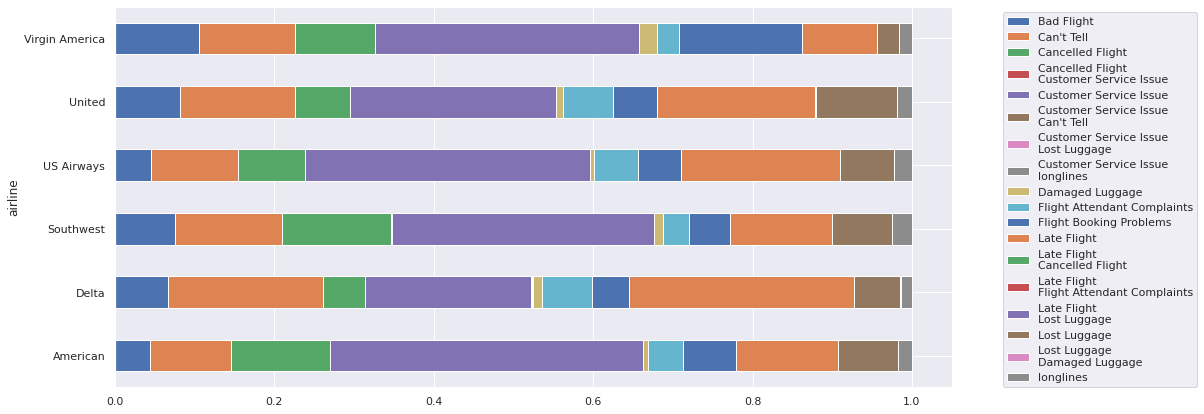

In [47]:
pd.crosstab(index = df.airline, columns = df.negativereason, normalize = 'index').plot(kind = 'barh', stacked = True, figsize = (15,7));
plt.legend(bbox_to_anchor = (1.3,1), loc = 'best');

- About 40% of the complaints about `American`/ `Southwest`/ `US Airways` are related to "Customer Service Issue".
- "Late Flight" is the #1 concern for `Delta`.
- For each airline except `Virgin America`, "Late Flight" and "Customer Service Issue" are two major issues.
- Besides "Customer Service Issue" being the #1 concern, "Flight Booking Problems" contributes to about 20% of the complaints about `Virgin America`.

### WordCloud for positive and negative sentiment

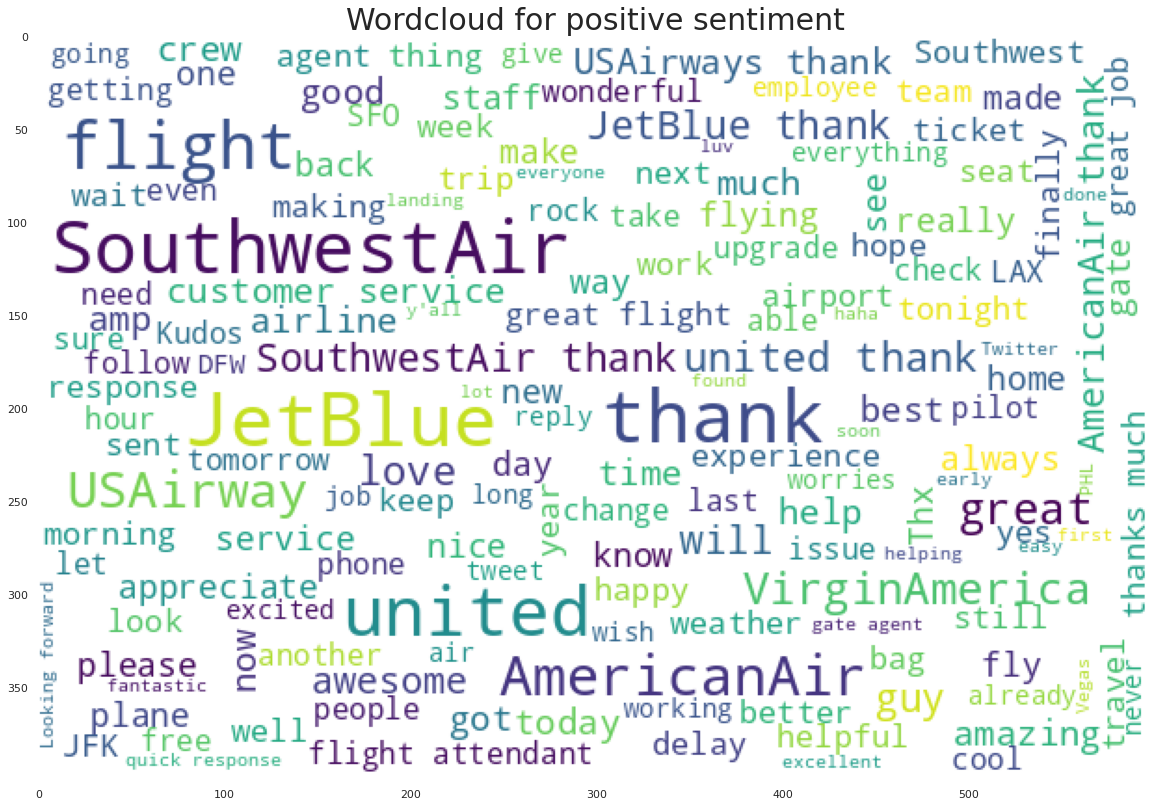

In [48]:
positive_text = df.loc[df['airline_sentiment'] == 'positive', 'text'].values
positive_text = ' '.join(positive_text)
plt.figure(figsize = (20, 20))
plt.grid(False)
plt.imshow(WordCloud(width=600, height=400,background_color = "white", 
                     max_font_size = 40,min_font_size = 10, max_words = 300, min_word_length = 3).generate(positive_text));
plt.title("Wordcloud for positive sentiment", fontsize = 30);

- In the wordcloud of positive sentiment, words that pop up frequently are: wonderful, thank, thanks much, best, happy, great, great job, awesome, best pilot, amazing, love, helpful, appreciate, well, nice, fantastic, etc .

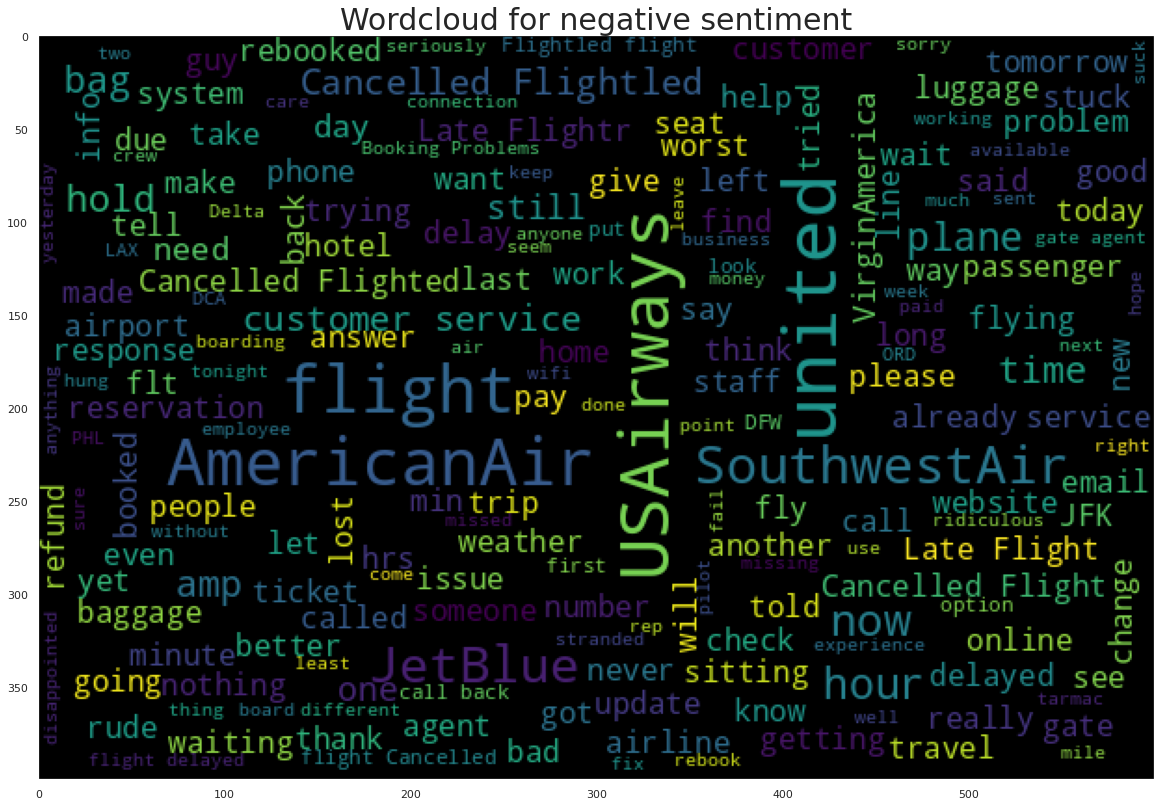

In [49]:
negative_text = df.loc[df['airline_sentiment'] == 'negative', 'text'].values
negative_text = ' '.join(negative_text)
plt.figure(figsize = (20, 20))
plt.grid(False)
plt.imshow(WordCloud(width=600, height=400,background_color = "black", 
                     max_font_size = 40,min_font_size = 10, max_words = 300, min_word_length = 3).generate(negative_text));
plt.title("Wordcloud for negative sentiment", fontsize = 30);

- In the wordcloud of negative sentiment, words that pop up frequently are: worst, rude, disappointed, problem, fail, refund, cancalled flight, cancelled flightled, late flight, customer service, booking problems, ridiculous, etc.

# Data Pre-processing
## Drop all the columns except `text` and `airline_sentiment`

In [50]:
df = df[["text","airline_sentiment"]]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [52]:
df.shape

(14640, 2)

- Randomly sample 10 reviews:

In [51]:
samples = df.sample(10, random_state = 8).text
samples.values

array(['@SouthwestAir aww thanks!! Other than that, love it!',
       "@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for 6k needed any suggestions? #letsgo!",
       "@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!",
       '@AmericanAir thanks',
       "@AmericanAir I still can't get through to change my flight. This is really important plz help!",
       '@AmericanAir your planes made me miss 2 connections in 2 days. Thanks for nothing',
       '@SouthwestAir I "heart" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.',
       '@SouthwestAir Thanks. 436. Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!',
       "@SouthwestAir thanks for your attention, I've been flying southwest for 3 years and haven't had this issue in the past.",
       "@So

- Besides the text, there're super links, mentions, hashtags and emojis in the review, which should be removed before model building.

In [53]:
backup = samples.copy()  # for debug

In [54]:
samples = backup.copy()   # for debug

## Html tag removal

In [55]:
def remove_html(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [56]:
samples = samples.apply(lambda x: remove_html(x))
samples.values

array(['@SouthwestAir aww thanks!! Other than that, love it!',
       "@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for 6k needed any suggestions? #letsgo!",
       "@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!",
       '@AmericanAir thanks',
       "@AmericanAir I still can't get through to change my flight. This is really important plz help!",
       '@AmericanAir your planes made me miss 2 connections in 2 days. Thanks for nothing',
       '@SouthwestAir I "heart" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.',
       '@SouthwestAir Thanks. 436. Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!',
       "@SouthwestAir thanks for your attention, I've been flying southwest for 3 years and haven't had this issue in the past.",
       "@So

## Remove the numbers

In [57]:
def remove_numbers(text):
    return re.sub('\d', '', text)

In [58]:
samples = samples.apply(lambda x: remove_numbers(x))
samples.values

array(['@SouthwestAir aww thanks!! Other than that, love it!',
       "@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for k needed any suggestions? #letsgo!",
       "@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 's are not too big... Not too small!",
       '@AmericanAir thanks',
       "@AmericanAir I still can't get through to change my flight. This is really important plz help!",
       '@AmericanAir your planes made me miss  connections in  days. Thanks for nothing',
       '@SouthwestAir I "heart" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.',
       '@SouthwestAir Thanks. . Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!',
       "@SouthwestAir thanks for your attention, I've been flying southwest for  years and haven't had this issue in the past.",
       "@SouthwestAir

## Expand contractions

In [59]:
def remove_contractions(text):
    return contractions.fix(text)

In [60]:
samples = samples.apply(lambda x: remove_contractions(x))
samples.values

array(['@SouthwestAir aww thanks!! Other than that, love it!',
       '@USAirways @AmericanAir I am in the #finalstretch to #chairman #execplat #mileagerun for k needed any suggestions? #letsgo!',
       "@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 's are not too big... Not too small!",
       '@AmericanAir thanks',
       '@AmericanAir I still cannot get through to change my flight. This is really important plz help!',
       '@AmericanAir your planes made me miss  connections in  days. Thanks for nothing',
       '@SouthwestAir I "heart" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.',
       '@SouthwestAir Thanks. . Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!',
       '@SouthwestAir thanks for your attention, I have been flying southwest for  years and have not had this issue in the past.',
       '@Southwe

## Removal of Special Characters and Punctuations

In [61]:
def remove_specialchars_punctuations(text):
    text = unicodedata.normalize('NFKD', text).encode("ascii", 'ignore').decode("utf-8", 'ignore')   # replace non-ascii characters with ascii characters
    text = re.sub('\@(\w+)', '', text)  # remove mentions
    return re.sub('[^\w\s]', '', text)   # remove punctuations

In [62]:
samples = samples.apply(lambda x: remove_specialchars_punctuations(x))
samples.values

array([' aww thanks Other than that love it',
       '  I am in the finalstretch to chairman execplat mileagerun for k needed any suggestions letsgo',
       ' we just flew with United from AUS Austin Bergstrom to Cancun Intl Best flight ever The s are not too big Not too small',
       ' thanks',
       ' I still cannot get through to change my flight This is really important plz help',
       ' your planes made me miss  connections in  days Thanks for nothing',
       ' I heart Southwest but those commercials aimed to satisfy a nanosmattering of travelers to few destinations',
       ' Thanks  Only a minor delay so not a big deal Appreciate the concern though Boarding now You do have amazing service',
       ' thanks for your attention I have been flying southwest for  years and have not had this issue in the past',
       ' guess where Ashley is she is doing a great job presenting ragandisney httptcoZNMwxDIU'],
      dtype=object)

## Convert to lowercase

In [63]:
def to_lowercase(text):
    return text.lower()

In [64]:
samples = samples.apply(lambda x: to_lowercase(x))
samples.values

array([' aww thanks other than that love it',
       '  i am in the finalstretch to chairman execplat mileagerun for k needed any suggestions letsgo',
       ' we just flew with united from aus austin bergstrom to cancun intl best flight ever the s are not too big not too small',
       ' thanks',
       ' i still cannot get through to change my flight this is really important plz help',
       ' your planes made me miss  connections in  days thanks for nothing',
       ' i heart southwest but those commercials aimed to satisfy a nanosmattering of travelers to few destinations',
       ' thanks  only a minor delay so not a big deal appreciate the concern though boarding now you do have amazing service',
       ' thanks for your attention i have been flying southwest for  years and have not had this issue in the past',
       ' guess where ashley is she is doing a great job presenting ragandisney httptcoznmwxdiu'],
      dtype=object)

## Tokenization

In [65]:
def tokenize(text):
    return word_tokenize(text)

In [66]:
samples = samples.apply(lambda x: tokenize(x))
samples.values

array([list(['aww', 'thanks', 'other', 'than', 'that', 'love', 'it']),
       list(['i', 'am', 'in', 'the', 'finalstretch', 'to', 'chairman', 'execplat', 'mileagerun', 'for', 'k', 'needed', 'any', 'suggestions', 'letsgo']),
       list(['we', 'just', 'flew', 'with', 'united', 'from', 'aus', 'austin', 'bergstrom', 'to', 'cancun', 'intl', 'best', 'flight', 'ever', 'the', 's', 'are', 'not', 'too', 'big', 'not', 'too', 'small']),
       list(['thanks']),
       list(['i', 'still', 'can', 'not', 'get', 'through', 'to', 'change', 'my', 'flight', 'this', 'is', 'really', 'important', 'plz', 'help']),
       list(['your', 'planes', 'made', 'me', 'miss', 'connections', 'in', 'days', 'thanks', 'for', 'nothing']),
       list(['i', 'heart', 'southwest', 'but', 'those', 'commercials', 'aimed', 'to', 'satisfy', 'a', 'nanosmattering', 'of', 'travelers', 'to', 'few', 'destinations']),
       list(['thanks', 'only', 'a', 'minor', 'delay', 'so', 'not', 'a', 'big', 'deal', 'appreciate', 'the', 'concern',

## Removal of stopwords
- Check the content in stopword list:

In [67]:
stopword_list = stopwords.words('english')
stopword_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

- Remove negations like "no", "not", "nor".
- Add additional stop words such as names of airlines.

In [68]:
stopword_list = set(stopword_list)  # convert the list into set
stopword_list -= set(["no", "not", "nor"])
stopword_list |= set(["united", "us", "airways", "usairway", "usairways", "american", "southwest", "southwestair", "delta", "virgin", "america", "virginamerica",
                      "americanair", "jetblue"])
stopword_list

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'airways',
 'all',
 'am',
 'america',
 'american',
 'americanair',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'delta',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'jetblue',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',

In [69]:
def remove_stopwords(text):
    return [x for x in text if x not in stopword_list]

In [70]:
samples = samples.apply(lambda x: remove_stopwords(x))
samples.values

array([list(['aww', 'thanks', 'love']),
       list(['finalstretch', 'chairman', 'execplat', 'mileagerun', 'k', 'needed', 'suggestions', 'letsgo']),
       list(['flew', 'aus', 'austin', 'bergstrom', 'cancun', 'intl', 'best', 'flight', 'ever', 'not', 'big', 'not', 'small']),
       list(['thanks']),
       list(['still', 'not', 'get', 'change', 'flight', 'really', 'important', 'plz', 'help']),
       list(['planes', 'made', 'miss', 'connections', 'days', 'thanks', 'nothing']),
       list(['heart', 'commercials', 'aimed', 'satisfy', 'nanosmattering', 'travelers', 'destinations']),
       list(['thanks', 'minor', 'delay', 'not', 'big', 'deal', 'appreciate', 'concern', 'though', 'boarding', 'amazing', 'service']),
       list(['thanks', 'attention', 'flying', 'years', 'not', 'issue', 'past']),
       list(['guess', 'ashley', 'great', 'job', 'presenting', 'ragandisney', 'httptcoznmwxdiu'])],
      dtype=object)

## Lemmatize or stemming

In [71]:
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    doc = nlp(' '.join(text))
    return ' '.join([x.lemma_ for x in doc])   # Join the words in the list to convert back to text string

In [72]:
samples = samples.apply(lambda x: lemmatize(x))
samples.values

array(['aww thank love',
       'finalstretch chairman execplat mileagerun k need suggestion letsgo',
       'fly aus austin bergstrom cancun intl good flight ever not big not small',
       'thank', 'still not get change flight really important plz help',
       'plane make miss connection day thank nothing',
       'heart commercial aim satisfy nanosmattere traveler destination',
       'thank minor delay not big deal appreciate concern though board amazing service',
       'thank attention fly year not issue past',
       'guess ashley great job present ragandisney httptcoznmwxdiu'],
      dtype=object)

## Assemble the above processes into one method and apply it on data

In [73]:
def text_preprocessing(text):
    text = remove_html(text)
    text = remove_numbers(text)
    text = remove_contractions(text)
    text = remove_specialchars_punctuations(text)
    text = to_lowercase(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [74]:
first_five_rows = df.head()
first_five_rows

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [75]:
first_five_rows.text.values

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it"],
      dtype=object)

In [76]:
df.text = df.text.apply(lambda x: text_preprocessing(x))
first_five_rows = df.head()
first_five_rows

,text,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,not today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


- Print the first 5 rows of data after pre-processing:

In [77]:
first_five_rows.text.values

array(['say', 'plus add commercial experience tacky',
       'not today must mean need take another trip',
       'really aggressive blast obnoxious entertainment guest face little recourse',
       'really big bad thing'], dtype=object)

# Vectorization
## Convert target variables to integers

In [141]:
X = df["text"]

# negative: 0
# positive: 1
# neutral: 2
y = df["airline_sentiment"].apply(lambda x: 0 if x == 'negative' else 1 if x == 'positive' else 2) 
y.head()

0    2
1    1
2    2
3    0
4    0
Name: airline_sentiment, dtype: int64

## Split data

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 22, stratify = y)

In [143]:
print(X_train.head())
print()
print(y_train.head())
print()
print(y_train.value_counts(1))

4629     crew great job keep everyone inform delay give...
6441     first interaction people morning bad weather s...
11502                                response day no thank
14530    thank force check carry luggage exactly spend ...
11553                                   good follow please
Name: text, dtype: object

4629     1
6441     0
11502    0
14530    1
11553    1
Name: airline_sentiment, dtype: int64

0    0.626952
2    0.211651
1    0.161397
Name: airline_sentiment, dtype: float64


In [89]:
print(X_train.shape, X_test.shape)

(10248,) (4392,)


## Convert to CountVectorizer

In [423]:
num_features = 500   # max features in vectorization

# In the EDA, we see the terms that appear most frequently are mostly uni-gram or bi-gram, 
# so it's reasonable to set ngram_range in both vectorizers to (1,2)
ngram = (1, 2) 

In [424]:
cvter = CountVectorizer(ngram_range = ngram, max_features = num_features) 
Xc_train = cvter.fit_transform(X_train).toarray()
Xc_test = cvter.transform(X_test).toarray()

# scaling Xc
scaler = StandardScaler()
Xc_train = scaler.fit_transform(Xc_train)
Xc_test = scaler.transform(Xc_test)

print(Xc_train.shape, Xc_test.shape)

(10248, 500) (4392, 500)


## Convert to TfidfVectorizer

In [425]:
tvter = TfidfVectorizer(ngram_range = ngram, max_features = num_features)
Xt_train = tvter.fit_transform(X_train).toarray()
Xt_test = tvter.transform(X_test).toarray()

# scaling Xt
scaler = StandardScaler()
Xt_train = scaler.fit_transform(Xt_train)
Xt_test = scaler.transform(Xt_test)

print(Xt_train.shape, Xt_test.shape)

(10248, 500) (4392, 500)


# Model Building

In [179]:
#  score function is recall_score
# Target is multiclass, so average need to be set as one of [None, 'micro', 'macro', 'weighted'].
# macro-average: compute the metric independently for each class and then take the average (hence treating all classes equally). 
# micro-average: aggregate the contributions of all classes to compute the average metric. 
# weighted-average: each class contribution to the average is weighted by the relative number of examples available for it.

# average = 'weighted'
# scorer = make_scorer(recall_score, average = average) 

In [180]:
# def compute_metrics(model, X_train, X_test, y_train, y_test):
#     """
#     This function is to compute accuracy, recall, precision and f1 score for both training set and test set.
    
#     Input:
#     model: model before fitting.
#     X_train: independent variables of training set. Dimension: (m, k).
#     y_train: true class labels of training set. Dimension: (m, ).    
#     X_test: independent variables of test set. Dimension: (n, k).
#     y_test: true class labels of test set. Dimension: (n, ). 


#     Return:
#     A model fitted with training set. Predictions and a dataframe of metrics for both training and test set.
#     """    
#     model = model.fit(X_train, y_train)
  
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)

#     accuracy_train = accuracy_score(y_train, y_pred_train)
#     accuracy_test = accuracy_score(y_test, y_pred_test)
    
#     precision_train = precision_score(y_train, y_pred_train, average = average)
#     precision_test = precision_score(y_test, y_pred_test, average = average)
    
#     recall_train = recall_score(y_train, y_pred_train, average = average)
#     recall_test = recall_score(y_test, y_pred_test, average = average)
    
#     metrics_df = pd.DataFrame([accuracy_train, accuracy_test, recall_train, recall_test, 
#                                                           precision_train, precision_test],
#                                                  index = ["Accuracy Train", "Accuracy Test", "Recall Train", "Recall Test", 
#                                                                     "Precision Train", "Precision Test"]).T
    
#     return model, y_pred_train, y_pred_test, metrics_df

In [259]:
scorer = "accuracy"
mc = dict()  # metrics for models working with CountVectorizer
mt = dict()   # metrics for models working with TfidfVectorizer

In [249]:
def compute_metrics(model, X_train, X_test, y_train, y_test):
    """
    This function is to compute accuracy, recall, precision and f1 score for both training set and test set.
    
    Input:
    model: model before fitting.
    X_train: independent variables of training set. Dimension: (m, k).
    y_train: true class labels of training set. Dimension: (m, ).    
    X_test: independent variables of test set. Dimension: (n, k).
    y_test: true class labels of test set. Dimension: (n, ). 


    Return:
    A model fitted with training set. Predictions and a dataframe of metrics for both training and test set.
    """    
    model = model.fit(X_train, y_train)
  
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    metrics_df = pd.DataFrame([accuracy_train, accuracy_test], index = ["Accuracy Train", "Accuracy Test"]).T
    
    return model, y_pred_train, y_pred_test, metrics_df

In [250]:
def show_confusion_matrix(y_true, y_pred, labels = [0, 1, 2]):
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize = (7,5))    
    sns.heatmap(matrix, xticklabels = labels, yticklabels = labels, fmt = ".0f", annot = True)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

## CatBoostClassifier
### CountVectorizer

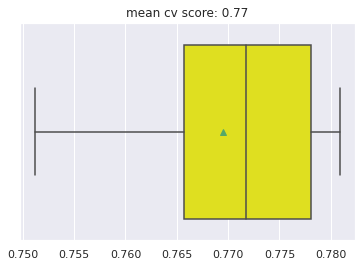

In [426]:
cbc = CatBoostClassifier(loss_function = "MultiClass", verbose = 0, random_seed=2)
cv_scores = cross_val_score(cbc, Xc_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.750 and 0.780, with the mean of 0.77.

In [427]:
cbc, y_pred_train, y_pred_test, mc["Cbc"] = compute_metrics(cbc, Xc_train, Xc_test, y_train, y_test)
mc["Cbc"]

,Accuracy Train,Accuracy Test
0,0.811573,0.78051


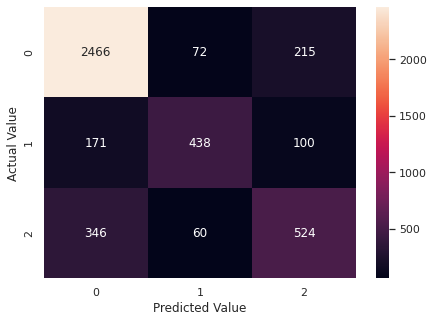

In [428]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.780. No overfitting.

In [429]:
cbc_tuned = CatBoostClassifier(loss_function = "MultiClass", verbose = 0, random_seed=2)
para = {
    "n_estimators": [1000, 1500],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    "depth": [3, 5, 7],
}
clf = RandomizedSearchCV(cbc_tuned, param_distributions = para, n_iter=20, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xc_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 1000, 'learning_rate': 0.3, 'depth': 3}
0.7711754692949565


In [430]:
cbc_tuned, y_pred_train, y_pred_test, mc["Cbc_tuned"] = compute_metrics(clf.best_estimator_, Xc_train, Xc_test, y_train, y_test)
mc["Cbc_tuned"]

,Accuracy Train,Accuracy Test
0,0.812744,0.782104


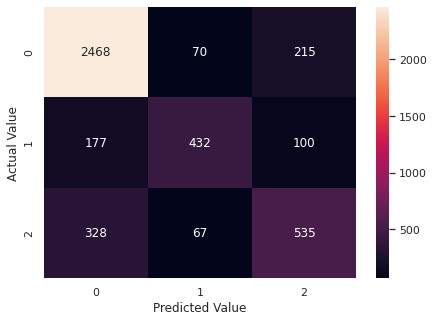

In [431]:
show_confusion_matrix(y_test, y_pred_test)

In [432]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2753
           1       0.76      0.61      0.68       709
           2       0.63      0.58      0.60       930

    accuracy                           0.78      4392
   macro avg       0.74      0.69      0.71      4392
weighted avg       0.78      0.78      0.78      4392



- After fine tuning, test accuracy gets little improvement. Based on the classification report, class 0 gains a good recall of 0.90, while class 1 and class 2 gains recall of about 0.6. For airline companies, identifying and promptly handling negative sentiments is more important than detecting positive or neutral sentiments. So the recall score of around 0.9 for negative sentiments is a desirable result.

### TfidfVectorizer

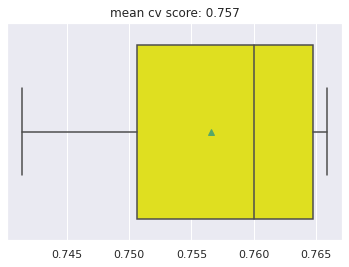

In [433]:
cbc_new = CatBoostClassifier(loss_function = "MultiClass", verbose = 0, random_seed=2)
cv_scores = cross_val_score(cbc_new, Xt_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.740 and 0.765, with the mean of 0.757.

In [434]:
cbc_new, y_pred_train, y_pred_test, mt["Cbc"] = compute_metrics(cbc_new, Xt_train, Xt_test, y_train, y_test)
mt["Cbc"]

,Accuracy Train,Accuracy Test
0,0.807865,0.76184


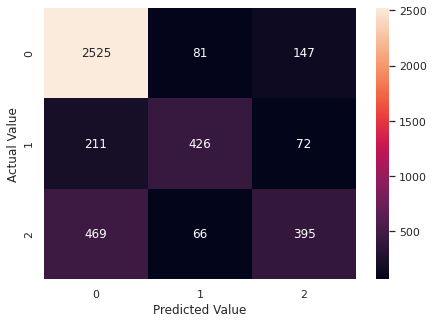

In [435]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.76. No overfitting.

In [436]:
cbc_tuned_new = CatBoostClassifier(loss_function = "MultiClass", verbose = 0, random_seed=2)
para = {
    "n_estimators": [1000, 1500],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    "depth": [3, 5, 7],
}
clf = RandomizedSearchCV(cbc_tuned_new, param_distributions = para, n_iter=20, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xt_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 1500, 'learning_rate': 0.3, 'depth': 3}
0.7568318156388005


In [437]:
cbc_tuned_new, y_pred_train, y_pred_test, mt["Cbc_tuned"] = compute_metrics(clf.best_estimator_, Xt_train, Xt_test, y_train, y_test)
mt["Cbc_tuned"]

,Accuracy Train,Accuracy Test
0,0.829528,0.760701


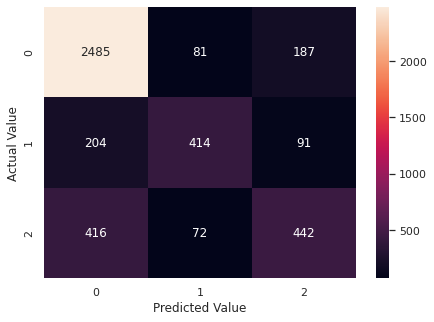

In [438]:
show_confusion_matrix(y_test, y_pred_test)

In [439]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2753
           1       0.73      0.58      0.65       709
           2       0.61      0.48      0.54       930

    accuracy                           0.76      4392
   macro avg       0.71      0.65      0.68      4392
weighted avg       0.75      0.76      0.75      4392



- After fine tuning, no improvement for the test accuracy.

## AdaBoostClassifier
### CountVectorizer

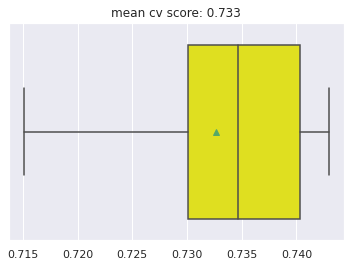

In [440]:
adc = AdaBoostClassifier(random_state=2)
cv_scores = cross_val_score(adc, Xc_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.715 and 0.745, with the mean of 0.73.

In [441]:
adc, y_pred_train, y_pred_test, mc["Adc"] = compute_metrics(adc, Xc_train, Xc_test, y_train, y_test)
mc["Adc"]

,Accuracy Train,Accuracy Test
0,0.74034,0.740437


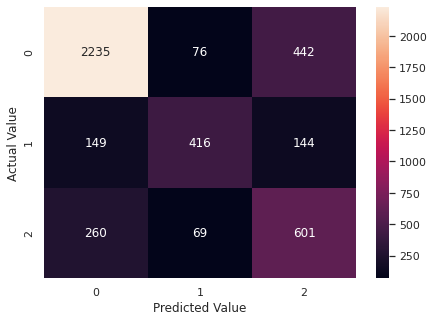

In [442]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.74. No overfitting.

In [443]:
adc_tuned = AdaBoostClassifier(random_state=2)
para = {
    "n_estimators": np.arange(50, 400, 20),
    "learning_rate": [0.2, 0.4, 0.6, 0.8],
}
clf = RandomizedSearchCV(adc_tuned, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xc_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 370, 'learning_rate': 0.4}
0.7657114356795105


In [444]:
adc_tuned, y_pred_train, y_pred_test, mc["Adc_tuned"] = compute_metrics(clf.best_estimator_, Xc_train, Xc_test, y_train, y_test)
mc["Adc_tuned"]

,Accuracy Train,Accuracy Test
0,0.780933,0.775956


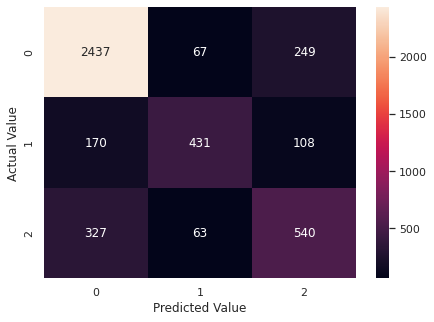

In [445]:
show_confusion_matrix(y_test, y_pred_test)

In [446]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2753
           1       0.77      0.61      0.68       709
           2       0.60      0.58      0.59       930

    accuracy                           0.78      4392
   macro avg       0.73      0.69      0.71      4392
weighted avg       0.77      0.78      0.77      4392



- After fine tuning, test accuracy is improved to 0.776. No overfitting. Based on the classification report, class 0 gains a good recall of 0.89, while class 1 and class 2 gains recall of about 0.6. For airline companies, identifying and promptly handling negative sentiments is more important than detecting positive or neutral sentiments. So the recall score of around 0.9 for negative sentiments is a desirable result.

### TfidfVectorizer

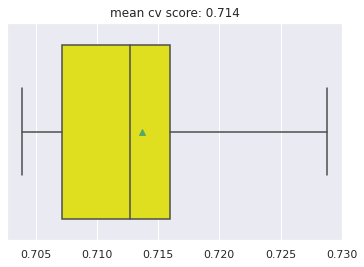

In [447]:
adc_new = AdaBoostClassifier(random_state=2)
cv_scores = cross_val_score(adc_new, Xt_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.705 and 0.730, with the mean of 0.714.

In [448]:
adc_new, y_pred_train, y_pred_test, mt["Adc"] = compute_metrics(adc_new, Xt_train, Xt_test, y_train, y_test)
mt["Adc"]

,Accuracy Train,Accuracy Test
0,0.727752,0.731102


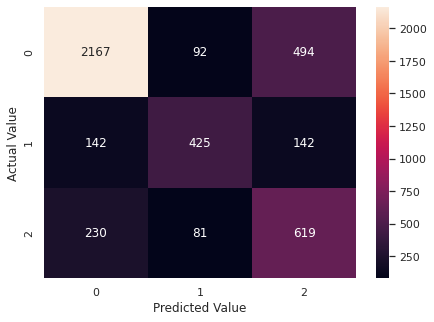

In [449]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.73. No overfitting.

In [450]:
adc_tuned_new = AdaBoostClassifier(random_state=2)
para = {
    "n_estimators": np.arange(50, 400, 20),
    "learning_rate": [0.2, 0.4, 0.6, 0.8],
}
clf = RandomizedSearchCV(adc_tuned_new, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xt_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 210, 'learning_rate': 0.6}
0.7614184670690045


In [451]:
adc_tuned_new, y_pred_train, y_pred_test, mt["Adc_tuned"] = compute_metrics(clf.best_estimator_, Xt_train, Xt_test, y_train, y_test)
mt["Adc_tuned"]

,Accuracy Train,Accuracy Test
0,0.780738,0.766393


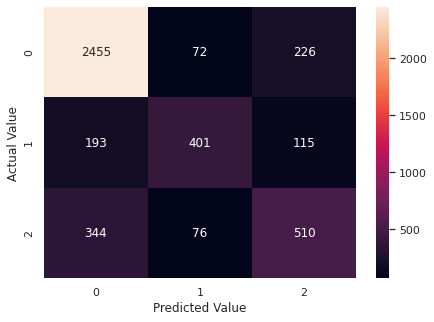

In [452]:
show_confusion_matrix(y_test, y_pred_test)

In [453]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2753
           1       0.73      0.57      0.64       709
           2       0.60      0.55      0.57       930

    accuracy                           0.77      4392
   macro avg       0.72      0.67      0.69      4392
weighted avg       0.76      0.77      0.76      4392



- After fine tuning, test accuracy is improved to 0.766. No overfitting. The classification result is similar to CountVectorizer.

## RandomForestClassifier
### CountVectorizer

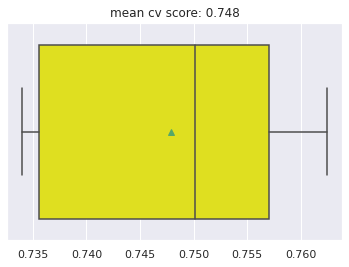

In [465]:
rfc = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
cv_scores = cross_val_score(rfc, Xc_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.735 and 0.760, with the mean of 0.75.

In [466]:
rfc, y_pred_train, y_pred_test, mc["Rfc"] = compute_metrics(rfc, Xc_train, Xc_test, y_train, y_test)
mc["Rfc"]

,Accuracy Train,Accuracy Test
0,0.975215,0.753643


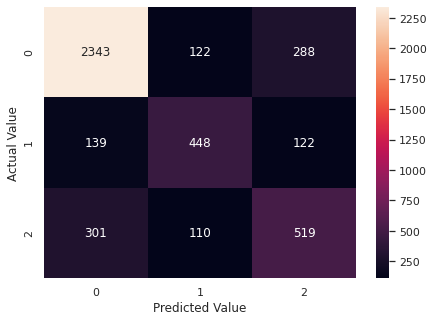

In [467]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.75 but it's overfitting.

In [468]:
rfc_tuned = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
para = {
    "n_estimators": np.arange(100, 700, 100),
    "max_features": [0.5, 0.6, 0.7, "sqrt", "log2", None],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1],
    "max_depth": [3, 4, 5, 6, 7],
}
clf = RandomizedSearchCV(rfc_tuned, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xc_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 7}
0.7132137747146139


In [469]:
rfc_tuned, y_pred_train, y_pred_test, mc["Rfc_tuned"] = compute_metrics(clf.best_estimator_, Xc_train, Xc_test, y_train, y_test)
mc["Rfc_tuned"]

,Accuracy Train,Accuracy Test
0,0.730484,0.721311


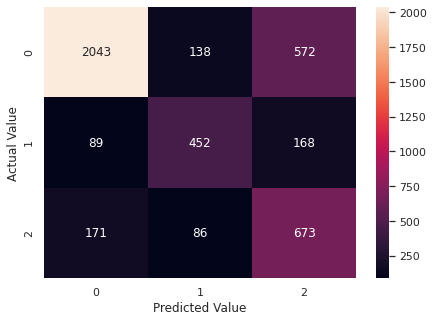

In [470]:
show_confusion_matrix(y_test, y_pred_test)

In [471]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      2753
           1       0.67      0.64      0.65       709
           2       0.48      0.72      0.57       930

    accuracy                           0.72      4392
   macro avg       0.68      0.70      0.68      4392
weighted avg       0.76      0.72      0.73      4392



- After fine tuning, test accuracy becomes lower but no more overfitting. 

### TfidfVectorizer

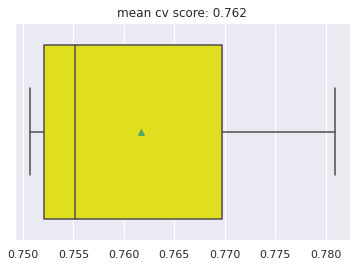

In [474]:
rfc_new = RandomForestClassifier(n_jobs = -1, random_state=2)
cv_scores = cross_val_score(rfc_new, Xt_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.750 and 0.780, with the mean of 0.762.

In [475]:
rfc_new, y_pred_train, y_pred_test, mt["Rfc"] = compute_metrics(rfc_new, Xt_train, Xt_test, y_train, y_test)
mt["Rfc"]

,Accuracy Train,Accuracy Test
0,0.975117,0.75888


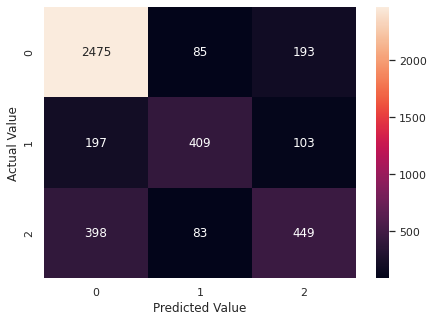

In [476]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.76 and it's overfitting.

In [477]:
rfc_tuned_new = RandomForestClassifier(n_jobs = -1, random_state=2)
para = {
    "n_estimators": np.arange(100, 700, 100),
    "max_features": [0.5, 0.6, 0.7, "sqrt", "log2", None],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1],
    "max_depth": [3, 4, 5, 6, 7],
}
clf = RandomizedSearchCV(rfc_tuned_new, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xt_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'max_depth': 7}
0.6931120237117452


In [478]:
rfc_tuned_new, y_pred_train, y_pred_test, mt["Rfc_tuned"] = compute_metrics(clf.best_estimator_, Xt_train, Xt_test, y_train, y_test)
mt["Rfc_tuned"]

,Accuracy Train,Accuracy Test
0,0.699063,0.688297


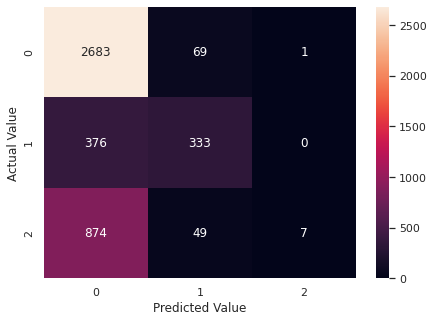

In [479]:
show_confusion_matrix(y_test, y_pred_test)

In [480]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2753
           1       0.74      0.47      0.57       709
           2       0.88      0.01      0.01       930

    accuracy                           0.69      4392
   macro avg       0.77      0.48      0.46      4392
weighted avg       0.73      0.69      0.60      4392



- After fine tuning, test accuracy becomes lower but no more overfitting. Recall of class 0 is very high, approaching 100%, at the cost of class 1 recall below 0.5 and class 2 recall approaching 0.

## Neural Network

In [407]:
num_class = y_train.nunique()
input_dim =  Xc_train.shape[1]
maxnorm = MaxNorm(3)

# convert target to one-hot encoding
y_train_oh = to_categorical(y_train, num_classes=num_class, dtype = "int32")
y_test_oh = to_categorical(y_test, num_classes=num_class, dtype = "int32")

In [344]:
def training_loss(history):
    plt.figure(figsize = (20,5));

    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

### CountVectorizer

In [416]:
def build_model():
    model = Sequential()
    
    model.add(Dense(units = 50, input_dim = input_dim, activation = "relu", kernel_initializer= "he_normal", kernel_constraint = maxnorm))
    model.add(Dropout(0.5))
    
    model.add(Dense(units = 25, kernel_initializer= "he_normal", kernel_constraint = maxnorm))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))  
    
    model.add(Dense(units = num_class, activation = "softmax", kernel_initializer= "glorot_normal"))
    
    optimizer = Adam(learning_rate=0.001, epsilon=1e-07)  # learning rate by default is 0.001 
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = [ "accuracy" ])
    return model

In [417]:
m1 = build_model()
m1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 50)                25050     
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 25)                1275      
_________________________________________________________________
batch_normalization_7 (Batch (None, 25)                100       
_________________________________________________________________
activation_7 (Activation)    (None, 25)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 3)               

In [418]:
history = m1.fit(x = Xc_train, y = y_train_oh, epochs=50, validation_split=0.2, verbose = 1)

Epoch 1/50
257/257 [==============================] - 1s 2ms/step - loss: 1.0462 - accuracy: 0.5271 - val_loss: 0.7787 - val_accuracy: 0.6546
Epoch 2/50
257/257 [==============================] - 0s 2ms/step - loss: 0.8206 - accuracy: 0.6397 - val_loss: 0.7194 - val_accuracy: 0.7068
Epoch 3/50
257/257 [==============================] - 0s 2ms/step - loss: 0.7524 - accuracy: 0.6700 - val_loss: 0.6797 - val_accuracy: 0.7385
Epoch 4/50
257/257 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.6919 - val_loss: 0.6495 - val_accuracy: 0.7517
Epoch 5/50
257/257 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.7081 - val_loss: 0.6217 - val_accuracy: 0.7615
Epoch 6/50
257/257 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.7214 - val_loss: 0.6034 - val_accuracy: 0.7590
Epoch 7/50
257/257 [==============================] - 1s 2ms/step - loss: 0.6096 - accuracy: 0.7354 - val_loss: 0.5927 - val_accuracy: 0.7688
Epoch 

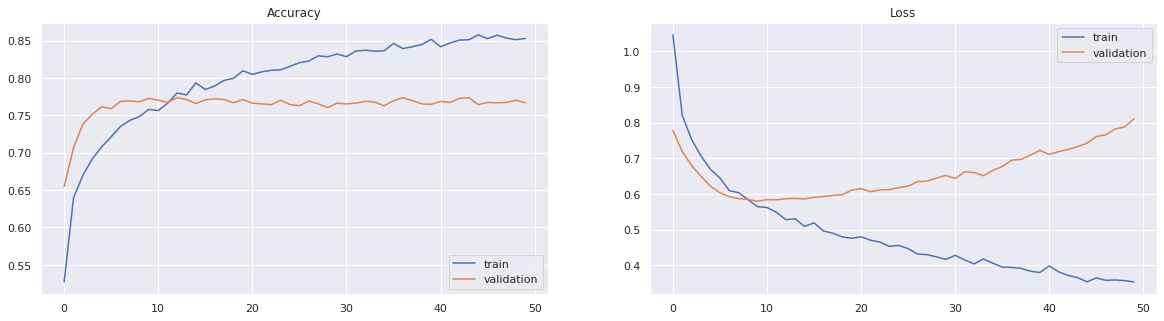

In [419]:
training_loss(history)

In [484]:
m1.evaluate(Xc_train, y_train_oh)
m1.evaluate(Xc_test, y_test_oh)

138/138 [==============================] - 0s 958us/step - loss: 0.8215 - accuracy: 0.7596


[0.8215177655220032, 0.7595628499984741]

## Comparison of models

In [481]:
mc_comparison = pd.concat(list(mc.values()))
mc_comparison.index = list(mc.keys())
mc_comparison.sort_values(by = "Accuracy Test", ascending = False)    # for CountVectorizer

,Accuracy Train,Accuracy Test
Cbc_tuned,0.812744,0.782104
Cbc,0.811573,0.780510
Adc_tuned,0.780933,0.775956
Rfc,0.975215,0.753643
Adc,0.740340,0.740437
Rfc_tuned,0.730484,0.721311


In [482]:
mt_comparison = pd.concat(list(mt.values()))
mt_comparison.index = list(mt.keys())
mt_comparison.sort_values(by = "Accuracy Test", ascending = False)  # for TF-IDF vectorizer 

,Accuracy Train,Accuracy Test
Adc_tuned,0.780738,0.766393
Cbc,0.807865,0.761840
Cbc_tuned,0.829528,0.760701
Rfc,0.975117,0.758880
Adc,0.727752,0.731102
Rfc_tuned,0.699063,0.688297


# Conclusion